In [99]:
import os
import openai
import pandas as pd
from p_tqdm import p_map
from tqdm.auto import tqdm
from dotenv import load_dotenv, find_dotenv

pd.set_option('display.max_colwidth', 512)
pd.set_option('display.max_columns', None)

class InferenceGPT():
    def __init__(self, model="gpt-3.5-turbo", temperature=0) -> None:
        _ = load_dotenv(find_dotenv())  # read local .env file
        openai.api_key = os.getenv('OPENAI_API_KEY')
        self.model = model
        self.temperature = temperature

    def run_prompts(self, prompts):
        raw_responses = p_map(self._get_completion, prompts, num_cpus=10, tqdm=tqdm)
        # raw_responses = [self._get_completion(p) for p in prompts]
        response = [r["final_content"] for r in raw_responses]
        return response, raw_responses

    def _get_completion(self, prompt):
        client = openai.OpenAI()
        response = client.chat.completions.create(
            model=self.model,
            temperature=self.temperature,
            top_p=0,
            messages=[{"role": "user", "content": prompt}]
        )
        response = response.model_dump()  # ChatCompletion Class to dict (pydantic)
        response["final_content"] = response["choices"][0]["message"]["content"]
        return response

# MODEL = "gpt-4o-mini-2024-07-18"
MODEL = "gpt-4o-2024-08-06"
gpt = InferenceGPT(model=MODEL, temperature=0)
gpt_eval = InferenceGPT(model="gpt-4o-2024-08-06", temperature=0)

# Make Poison

In [26]:
df = pd.read_json("dataset/foil.jsonl", lines=True)
few_shot = """QUESTION: who won a million on deal or no deal
Answer: Tomorrow Rodriguez

QUESTION: When did the publisher of Tetrisphere unveil their new systems?
Answer: October 18, 1985

QUESTION: who is the woman washing the car in cool hand luke
Answer: Joy Harmon
"""
def prompt_template(query, doc=None):
    if doc is not None:
        return f"Answer the question based on the given document. Only give me the answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: {doc}\n\nQuestion: {query} Answer: "
    else:
        return f"Answer the question. Only give me the answer and do not output any other words.\n\nQuestion: {query} Answer:"

def flatten(xss):
    return [x for xs in xss for x in xs]

df["evidence_sentence"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["foil_doc_prompt"] = df.apply(lambda row: prompt_template(row["query"], row["sents_complete_wo_foil"]), axis=1)
df["evidence_doc_prompt"] = df.apply(lambda row: prompt_template(row["query"], row["sents_complete_w_foil"]), axis=1)
df["query_prompt"] = df.apply(lambda row: prompt_template(row["query"]), axis=1)

df[["title", "query", "sents_complete_w_foil", "sents_complete_wo_foil", "relation_name", "tail_entity_names", "tail_entity_longest_name", "evidence_sents", "evidence_sentence"]]

replacements = [("10, ", "10 , "), ("22, ", "22 , "), ("15, ", "15 , "), ("13, ", "13 , "), ("17, ", "17 , "), ("Jazz", "jazz")]
for r in replacements:
    df["tail_entity_longest_name"] = df["tail_entity_longest_name"].str.replace(r[0], r[1])

df[["sents_complete_wo_foil", "tail_entity_longest_name"]]
for r in df.to_dict(orient="records"):
    if r["tail_entity_longest_name"] not in r["evidence_sentence"]:
        print(r["tail_entity_longest_name"], "|", r["evidence_sentence"])
        print(r)
        
df_raw = df.copy()

the United States | " How to Save a Life " is the twenty - first episode of the eleventh season of the American television medical drama Grey 's Anatomy , and is the 241st episode overall .
{'query': 'What is the country of origin of How to Save a Life?', 'gold_docs': ["How to Save a Life (Grey's Anatomy)"], 'gold_docs_text': {"How to Save a Life (Grey's Anatomy)": {'text': '" How to Save a Life " is the twenty - first episode of the eleventh season of the American television medical drama Grey \'s Anatomy , and is the 241st episode overall . It aired on April 23 , 2015 on ABC in the United States . The episode was written by showrunner Shonda Rhimes and directed by Rob Hardy , making it the first episode Rhimes has written since the season eight finale " Flight " . The installment marked the death and final appearance of the series’ male lead character , Derek Shepherd ( Patrick Dempsey ) , who had starred on the series since its inception . In this episode , Shepherd is involved in a

In [27]:
df = df_raw.copy()
# df = df.sample(1)

def poison_replace_prompt(tail, evidence):
    return f"In the sentence: '{evidence}', replace the entity '{tail}' with a different entity that makes sense in context but is completely different. Output only the replacement entity. replacement entity: "

df["poison_replace_prompt"] = df.apply(lambda row: poison_replace_prompt(row["tail_entity_longest_name"], row["evidence_sentence"]), axis=1)
df["poison_replace_prompt_output"] = gpt.run_prompts(df["poison_replace_prompt"])[0]
df["poison_doc"] = df.apply(lambda row: row["sents_complete_wo_foil"] + row["evidence_sentence"].replace(row["tail_entity_longest_name"], row["poison_replace_prompt_output"]), axis=1)
df["poison_doc_prompt"] = df.apply(lambda row: prompt_template(row["query"], row["poison_doc"]), axis=1)
df

  0%|          | 0/250 [00:00<?, ?it/s]

,query,gold_docs,gold_docs_text,scores_stats,scores_gold,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,sents_complete_w_foil,sents_complete_wo_foil,evidence_sentence,foil_doc_prompt,evidence_doc_prompt,query_prompt,poison_replace_prompt,poison_replace_prompt_output,poison_doc,poison_doc_prompt
0,When was The Private Life of Helen of Troy published?,[The Private Life of Helen of Troy],"{'The Private Life of Helen of Troy': {'text': 'The Private Life of Helen of Troy is a 1927 American silent film about Helen of Troy based on the 1925 novel of the same name by John Erskine , and adapted to screen by Gerald Duffy . The film was directed by Alexander Korda and starred María Corda as Helen , Lewis Stone as Menelaus , and Ricardo Cortez as Paris . Coming at the end of the silent film era , it was nominated for an Academy Award in 1929 , the year of the Awards ' inception , in the category ...","{'len': 1000, 'max': 392.3541870117, 'min': 373.9404907227, 'std': 1.3496554124, 'mean': 375.2744338684, 'median': 374.9059753418}",{'The Private Life of Helen of Troy': 392.3541870117},"{'The Private Life of Helen of Troy': {'text': 'The Private Life of Helen of Troy is a 1927 American silent film about Helen of Troy based on the 1925 novel of the same name by John Erskine , and adapted to screen by Gerald Duffy . The film was directed by Alexander Korda and starred María Corda as Helen , Lewis Stone as Menelaus , and Ricardo Cortez as Paris . Coming at the end of the silent film era , it was nominated for an Academy Award in 1929 , the year of the Awards ' inception , in the category ...",validation13053,The Private Life of Helen of Troy,"[[{'name': 'The Private Life of Helen of Troy', 'pos': [0, 7], 'sent_id': 0, 'type': 'MISC', 'global_pos': [0, 0], 'index': '0_0'}, {'name': 'The Private Life of Helen of Troy', 'pos': [21, 28], 'sent_id': 5, 'type': 'MISC', 'global_pos': [187, 187], 'index': '0_1'}, {'type': 'MISC', 'pos': [29, 36], 'name': 'The Private Life of Helen of Troy', 'sent_id': 4, 'global_pos': [149, 149], 'index': '0_2'}], [{'type': 'TIME', 'pos': [9, 10], 'name': '1927', 'sent_id': 0, 'global_pos': [9, 9], 'index': '1_0'}],...","[{'r': 'P577', 'h': 0, 't': 1, 'evidence': [0]}, {'r': 'P577', 'h': 0, 't': 5, 'evidence': [0]}, {'r': 'P57', 'h': 0, 't': 8, 'evidence': [1]}, {'r': 'P161', 'h': 0, 't': 9, 'evidence': [1]}, {'r': 'P161', 'h': 0, 't': 10, 'evidence': [1]}, {'r': 'P161', 'h': 0, 't': 12, 'evidence': [1]}, {'r': 'P58', 'h': 0, 't': 7, 'evidence': [0]}, {'r': 'P570', 'h': 7, 't': 17, 'evidence': [3]}, {'r': 'P571', 'h': 19, 't': 15, 'evidence': [2]}, {'r': 'P585', 'h': 16, 't': 15, 'evidence': [2]}, {'r': 'P31', 'h': 16, ...","[[The, Private, Life, of, Helen, of, Troy, is, a, 1927, American, silent, film, about, Helen, of, Troy, based, on, the, 1925, novel, of, the, same, name, by, John, Erskine, ,, and, adapted, to, screen, by, Gerald, Duffy, .], [The, film, was, directed, by, Alexander, Korda, and, starred, María, Corda, as, Helen, ,, Lewis, Stone, as, Menelaus, ,, and, Ricardo, Cortez, as, Paris, .], [Coming, at, the, end, of, the, silent, film, era, ,, it, was, nominated, for, an, Academy, Award, in, 1929, ,, the, year, o...",validation,"{'r': 'P577', 'h': 0, 't': 1, 'evidence': [0]}",0,"[{'name': 'The Private Life of Helen of Troy', 'pos': [0, 7], 'sent_id': 0, 'type': 'MISC', 'global_pos': [0, 0], 'index': '0_0'}, {'name': 'The Private Life of Helen of Troy', 'pos': [21, 28], 'sent_id': 5, 'type': 'MISC', 'global_pos': [187, 187], 'index': '0_1'}, {

In [28]:
df.to_json("dataset/poison.jsonl", lines=True, orient="records")

# GPT RAG

In [100]:
df_raw = pd.read_json("dataset/poison.jsonl", lines=True)
def prompt_template(query, doc=None):
    if doc is not None:
        return f"Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: {doc}\n\nQuestion: {query} Answer: "
    else:
        return f"Answer the question. Only give me the answer and do not output any other words.\n\nQuestion: {query} Answer:"
df = df_raw.copy()
df["foil_doc_prompt"] = df.apply(lambda row: prompt_template(row["query"], row["sents_complete_wo_foil"]), axis=1)
df["evidence_doc_prompt"] = df.apply(lambda row: prompt_template(row["query"], row["sents_complete_w_foil"]), axis=1)
df["query_prompt"] = df.apply(lambda row: prompt_template(row["query"]), axis=1)
df["poison_doc_prompt"] = df.apply(lambda row: prompt_template(row["query"], row["poison_doc"]), axis=1)
df_raw = df
df_raw.sample(1)

,query,gold_docs,gold_docs_text,scores_stats,scores_gold,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,sents_complete_w_foil,sents_complete_wo_foil,evidence_sentence,foil_doc_prompt,evidence_doc_prompt,query_prompt,poison_replace_prompt,poison_replace_prompt_output,poison_doc,poison_doc_prompt
245,Which country is Bad Astronaut associated with?,[Bad Astronaut],"{'Bad Astronaut': {'text': 'Bad Astronaut is an American indie / alternative rock band founded in 2000 by Joey Cape , singer from Lagwagon . In Bad Astronaut , Joey Cape explores a style of alternative rock , with lyrics often about deep and intricate personal matters . The band released its debut album , "" Acrophobe "" in 2001 , followed by in 2002 on "" Honest Don 's Records . "" The band released its third and final album , Twelve Small Steps , One Giant Disappointment on November 14 , 2006 on Fat Wreck...","{'len': 1000, 'max': 384.3588867188, 'min': 371.5714111328, 'std': 1.269427409, 'mean': 372.7611032715, 'median': 372.3481140137}",{'Bad Astronaut': 384.3588867188},"{'Bad Astronaut': {'text': 'Bad Astronaut is an American indie / alternative rock band founded in 2000 by Joey Cape , singer from Lagwagon . In Bad Astronaut , Joey Cape explores a style of alternative rock , with lyrics often about deep and intricate personal matters . The band released its debut album , "" Acrophobe "" in 2001 , followed by in 2002 on "" Honest Don 's Records . "" The band released its third and final album , Twelve Small Steps , One Giant Disappointment on November 14 , 2006 on Fat Wreck...",test7745,Bad Astronaut,"[[{'name': 'Bad Astronaut', 'pos': [36, 38], 'sent_id': 4, 'type': 'ORG', 'global_pos': [131, 131], 'index': '0_0'}, {'name': 'Bad Astronaut', 'pos': [0, 2], 'sent_id': 0, 'type': 'ORG', 'global_pos': [0, 0], 'index': '0_1'}, {'name': 'Bad Astronaut', 'pos': [1, 3], 'sent_id': 1, 'type': 'ORG', 'global_pos': [22, 22], 'index': '0_2'}, {'name': 'Bad Astronaut', 'pos': [0, 2], 'sent_id': 7, 'type': 'ORG', 'global_pos': [161, 161], 'index': '0_3'}, {'name': 'Bad Astronaut', 'pos': [17, 19], 'sent_id': 4, '...","[{'r': 'P571', 'h': 0, 't': 2, 'evidence': [0]}, {'r': 'P527', 'h': 0, 't': 3, 'evidence': [0, 1]}, {'r': 'P112', 'h': 0, 't': 3, 'evidence': [0]}, {'r': 'P17', 'h': 0, 't': 1, 'evidence': [0]}, {'r': 'P527', 'h': 0, 't': 13, 'evidence': [0, 4, 5]}, {'r': 'P264', 'h': 0, 't': 8, 'evidence': [0, 2]}, {'r': 'P264', 'h': 5, 't': 8, 'evidence': [2]}, {'r': 'P156', 'h': 9, 't': 10, 'evidence': [3]}, {'r': 'P570', 'h': 13, 't': 15, 'evidence': [5]}, {'r': 'P155', 'h': 10, 't': 9, 'evidence': [3]}, {'h': 9, 't...","[[Bad, Astronaut, is, an, American, indie, /, alternative, rock, band, founded, in, 2000, by, Joey, Cape, ,, singer, from, Lagwagon, .], [In, Bad, Astronaut, ,, Joey, Cape, explores, a, style, of, alternative, rock, ,, with, lyrics, often, about, deep, and, intricate, personal, matters, .], [The, band, released, its, debut, album, ,, "", Acrophobe, "", in, 2001, ,, followed, by, in, 2002, on, "", Honest, Don, 's, Records, ., ""], [The, band, released, its, third, and, final, album, ,, Twelve, Small, Steps, ...",test,"{'r': 'P17', 'h': 0, 't': 1, 'evidence': [0]}",3,"[{'name': 'Bad Astronaut', 'pos': [36, 38], 'sent_id': 4, 'type': 'ORG', 'global_pos': [131, 131], 'index': '0_0'}, {'name': 'Bad Astronaut', 'pos': [0, 2], 'sent_id': 0, 'type': 'ORG', 'global_pos': [0, 0], 'index': '0_1'}, {'name': 'Bad Astronaut', 'pos': [1, 3], 'sent_id': 1, 'type': 'ORG', 'global_pos': [22, 22], 'index': '0_2'},

In [101]:
from difflib import SequenceMatcher

df = df_raw.copy()
# df = df.loc[[132]]
# df = df.sample(5)

def eval_template(query, model_answer, gold_answer, evidence_sentence):
    # return f"Query: {query}\nModel Answer: {model_answer}\n\nGold Answer: {gold_answer}\n\nDoes the Model Answer contain or imply the Gold Answer in meaning, allowing for synonyms, abbreviations, geographic hierarchy (e.g., a city or state can represent its country), and reasonable variations? YES or NO : "
    return f"Query: {query}\nEvidence: {evidence_sentence}\nGold Answer: {gold_answer}\n\nModel Answer: {model_answer}\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO : "

for part in ["poison_doc", "foil_doc", "evidence_doc", "query"]:  # ["poison_doc", "foil_doc", "evidence_doc", "query"]
    df[f"{part}_prompt_output"] = gpt.run_prompts(df[f"{part}_prompt"])[0]
    df[f"{part}_prompt_eval_prompt"] = df.apply(lambda row: eval_template(row['query'], row[f"{part}_prompt_output"], row['tail_entity_longest_name'], row["evidence_sentence"]), axis=1)
    df[f"{part}_prompt_eval_prompt_output"] = gpt_eval.run_prompts(df[f"{part}_prompt_eval_prompt"])[0]
    df[f"{part}_prompt_eval_prompt_output"] = df[f"{part}_prompt_eval_prompt_output"].apply(lambda s: s.upper().strip()[:3])
    df[f"{part}_prompt_eval_str_diff"] = df.apply(lambda r: SequenceMatcher(None, r[f"{part}_prompt_output"].lower().strip(), r['tail_entity_longest_name'].lower().strip()).ratio(), axis=1)

df["MODEL"] = MODEL
df.to_pickle(f"rag/eval_{MODEL}_{len(df)}.pkl")

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [102]:
dfc = df.copy()
dfc = dfc[["query", "evidence_sentence", "evidence_doc_prompt", "evidence_doc_prompt_output", "evidence_doc_prompt_eval_prompt", "evidence_doc_prompt_eval_prompt_output", f"evidence_doc_prompt_eval_str_diff"]]
dfc = dfc[dfc["evidence_doc_prompt_eval_prompt_output"] == "NO"]
dfc

,query,evidence_sentence,evidence_doc_prompt,evidence_doc_prompt_output,evidence_doc_prompt_eval_prompt,evidence_doc_prompt_eval_prompt_output,evidence_doc_prompt_eval_str_diff
33,Which administrative territorial entity is Camp Caves located in?,"Camp Caves was a US Army training camp north of the city of Rockhampton , Queensland , Australia .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: Paradise Cracked ( ) is a cyberpunk single - player turn - based strategy video game . It was created by MiST Land South ( renamed as GFI Russia in 2006 ) for Microsoft Windows and released in 2002 . It has several translation problems that make the game difficult to understand in English . The player starts as a character named "" Hacke...",Queensland,"Query: Which administrative territorial entity is Camp Caves located in?\nEvidence: Camp Caves was a US Army training camp north of the city of Rockhampton , Queensland , Australia .\nGold Answer: US\n\nModel Answer: Queensland\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :",NO,0.333333
54,What precedes Be Still My Beating Heart?,""" We 'll Be Together "" , "" Be Still My Beating Heart "" , "" Englishman in New York "" , "" Fragile "" , and "" They Dance Alone "" were all released as singles .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: Woodlawn is an unincorporated community and census - designated place in Baltimore County , Maryland , United States . The population was 37,879 at the 2010 census . It is home to the headquarters of the Social Security Administration ( SSA ) and the Centers for Medicare and Medicaid Services ( CMS ) . It is bordered by Catonsville on t...",We'll Be Together,"Query: What precedes Be Still My Beating Heart?\nEvidence: "" We 'll Be Together "" , "" Be Still My Beating Heart "" , "" Englishman in New York "" , "" Fragile "" , and "" They Dance Alone "" were all released as singles .\nGold Answer: Englishman in New York\n\nModel Answer: We'll Be Together\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :",NO,0.205128
64,Where is Quasi-War located?,"He served in Maryland during the Quasi - War with France and in Chesapeake , New York , and Constitution during operation in the Mediterranean against the Barbary pirates .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: The Enterprise Objects Framework , or more commonly simply EOF , was introduced by NeXT in 1994 as a pioneering object - relational mapping product for its NeXTSTEP and OpenStep development platforms . EOF abstracts the process of interacting with a relational database by mapping database rows to Java or Objective - C objects . This lar...",Maryland,"Query: Where is Quasi-War located?\nEvidence: He served in Maryland during the Quasi - War with France and in Chesapeake , New York , and Constitution during operation in the Mediterranean against the Barbary pirates .\nGold Answer: Mediterranean\n\nModel Answer: Maryland\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :",NO,0.380952
70,Who wrote the lyrics for Extraordinary Merry Christmas?,"The episode has the same name as an original song on that album , "" Extraordinary Merry Christmas "" , which was written for Glee by the show 's executive music producer Adam Anders , song producer Peer Åström , and Shelly Peiken .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: Allen County is a county in the U.S. state of Ohio . As of

In [79]:
dfc = df.copy()
dfc = dfc[["query", "evidence_sentence", "evidence_doc_prompt", "evidence_doc_prompt_output", "evidence_doc_prompt_eval_prompt", "evidence_doc_prompt_eval_prompt_output"]]
dfc = dfc[dfc["evidence_doc_prompt_eval_prompt_output"] == "NO"]
dfc

,query,evidence_sentence,evidence_doc_prompt,evidence_doc_prompt_output,evidence_doc_prompt_eval_prompt,evidence_doc_prompt_eval_prompt_output
0,When was The Private Life of Helen of Troy published?,"The Private Life of Helen of Troy is a 1927 American silent film about Helen of Troy based on the 1925 novel of the same name by John Erskine , and adapted to screen by Gerald Duffy .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: The discography of English rock band Joy Division consists of two studio albums , four live albums , twelve compilation albums , three extended plays , and five singles . The list does not include material performed by former members of Joy Division that was recorded as New Order ( formed by the surviving members of the band after the d...",The Private Life of Helen of Troy was published in 1925.,"Query: When was The Private Life of Helen of Troy published?\nModel Answer: The Private Life of Helen of Troy was published in 1925.\n\nGold Answer: 1927\n\nDoes the Model Answer contain or imply the Gold Answer in meaning, allowing for synonyms, abbreviations, geographic hierarchy (e.g., a city or state can represent its country), and reasonable variations? YES or NO :",NO
1,What is EMH an instance of?,"This is focused on an EMH ( The Doctor)-like hologram on another ship , which is dealt with mostly by the Doctor and B'Elanna .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: The University of Uyo ( UNIUYO ) is located in Uyo , capital of Akwa Ibom State , Nigeria . The university was formerly known as the University of Cross River State ( UNICROSS ) . On October 1 , 1991 the federal government of Nigeria established it as a federal university and the name was changed to the University of Uyo . The universit...",EMH is an instance of a hologram.,"Query: What is EMH an instance of?\nModel Answer: EMH is an instance of a hologram.\n\nGold Answer: Doctor\n\nDoes the Model Answer contain or imply the Gold Answer in meaning, allowing for synonyms, abbreviations, geographic hierarchy (e.g., a city or state can represent its country), and reasonable variations? YES or NO :",NO
3,What is a notable work of Miami Sound Machine?,Both of the corresponding albums ( Eyes of Innocence and Primitive Love ) were credited to Miami Sound Machine .,"Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: Yuriy Vitaliyovych Lutsenko (; born 14 December 1964 ) is a Ukrainian politician and the current Prosecutor General of Ukraine ( since 12 May 2016 ) . Lutsenko is a former Minister of Internal Affairs . He occupied this post in the two cabinets of Yulia Tymoshenko and in cabinets of Yuriy Yekhanurov , and Viktor Yanukovych . The Ministr...",The document does not provide information about notable works of Miami Sound Machine.,"Query: What is a notable work of Miami Sound Machine?\nModel Answer: The document does not provide information about notable works of Miami Sound Machine.\n\nGold Answer: Eyes of Innocence\n\nDoes the Model Answer contain or imply the Gold Answer in meaning, allowing for synonyms, abbreviations, geographic hierarchy (e.g., a city or state can represent its country), and reasonable variations? YES or NO :",NO
16,When was Chesapeake founded?,"Additionally , Amtrak operated a commuter service named the Chesapeake between 1978 – 1983 .","Answer the question based on the given document. Only give me the complete answer and do not output any other words.\n\nThe following is the given document.\n\nDocument: Isa is a town and Local Government Area in the state of Sokoto in Nigeria . It shares borders with Shinkafi in Zamfara State , goronyo and Sabon Birni fro

# Results

In [117]:
dfr = list()

paths = [
    "rag/eval_gpt-4o-mini-2024-07-18_250.pkl",
    "rag/eval_gpt-4o-2024-08-06_250.pkl",
]
for path in paths:
    df = pd.read_pickle(path)
    row = {"MODEL": df["MODEL"].iloc[0]}
    for part in ["poison_doc", "query", "foil_doc", "evidence_doc", ]:
        df[f"{part}_prompt_eval_prompt_output"] = df.apply(lambda row: "NO" if "document does not provide" in row[f"{part}_prompt_eval_prompt"] else row[f"{part}_prompt_eval_prompt_output"], axis=1)
        vc = df[f"{part}_prompt_eval_prompt_output"].value_counts()
        print(vc)
        row[part] = vc.get("YES", 0) / vc.sum()
    dfr.append(row)

dfr = pd.DataFrame(dfr)

dfr

poison_doc_prompt_eval_prompt_output
NO     170
YES     80
Name: count, dtype: int64
query_prompt_eval_prompt_output
YES    130
NO     120
Name: count, dtype: int64
foil_doc_prompt_eval_prompt_output
NO     140
YES    110
Name: count, dtype: int64
evidence_doc_prompt_eval_prompt_output
YES    220
NO      30
Name: count, dtype: int64
poison_doc_prompt_eval_prompt_output
NO     173
YES     77
Name: count, dtype: int64
query_prompt_eval_prompt_output
YES    162
NO      88
Name: count, dtype: int64
foil_doc_prompt_eval_prompt_output
YES    157
NO      93
Name: count, dtype: int64
evidence_doc_prompt_eval_prompt_output
YES    234
NO      16
Name: count, dtype: int64


,MODEL,poison_doc,query,foil_doc,evidence_doc
0,gpt-4o-mini-2024-07-18,0.320,0.520,0.440,0.880
1,gpt-4o-2024-08-06,0.308,0.648,0.628,0.936


In [116]:
df = pd.read_pickle("rag/eval_gpt-4o-mini-2024-07-18_250.pkl")
print(df.columns)
dfc = df.copy()
dfc = dfc[[
    "query", "evidence_sentence", 
    # "evidence_doc_prompt", "evidence_doc_prompt_output", "evidence_doc_prompt_eval_prompt", "evidence_doc_prompt_eval_prompt_output", f"evidence_doc_prompt_eval_str_diff",
    "foil_doc_prompt_eval_prompt", "foil_doc_prompt_eval_prompt_output",
    "query_prompt_eval_prompt", "query_prompt_eval_prompt_output",
]]
# dfc = dfc[dfc["evidence_doc_prompt_eval_prompt_output"] == "NO"]
dfc.sample(2)

Index(['query', 'gold_docs', 'gold_docs_text', 'scores_stats', 'scores_gold',
       'predicted_docs_text_10', 'id', 'title', 'vertexSet', 'labels', 'sents',
       'split', 'label', 'label_idx', 'head_entity', 'tail_entity',
       'head_entity_names', 'tail_entity_names', 'head_entity_longest_name',
       'tail_entity_longest_name', 'head_entity_types', 'tail_entity_types',
       'evidence_sent_ids', 'evidence_sents', 'head_entity_in_evidence',
       'tail_entity_in_evidence', 'relation', 'relation_name',
       'query_question', 'duplicate_titles_len', 'duplicate_titles',
       'hit_rank', 'gold_doc', 'gold_doc_title', 'gold_doc_text',
       'gold_doc_score', 'pred_doc', 'pred_doc_title', 'pred_doc_text',
       'pred_doc_score', 'gold_doc_len', 'pred_doc_len',
       'sents_complete_w_foil', 'sents_complete_wo_foil', 'evidence_sentence',
       'foil_doc_prompt', 'evidence_doc_prompt', 'query_prompt',
       'poison_replace_prompt', 'poison_replace_prompt_output', 'poison_doc'

,query,evidence_sentence,foil_doc_prompt_eval_prompt,foil_doc_prompt_eval_prompt_output,query_prompt_eval_prompt,query_prompt_eval_prompt_output
8,When was Elliott Arnold born?,"Elliott Arnold ( September 13 , 1912 – May 13 , 1980 ) was an American newspaper feature writer , novelist , and screenwriter .","Query: When was Elliott Arnold born?\nEvidence: Elliott Arnold ( September 13 , 1912 – May 13 , 1980 ) was an American newspaper feature writer , novelist , and screenwriter .\nGold Answer: September 13 , 1912\n\nModel Answer: The document does not provide information about Elliott Arnold's birth date.\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :",YES,"Query: When was Elliott Arnold born?\nEvidence: Elliott Arnold ( September 13 , 1912 – May 13 , 1980 ) was an American newspaper feature writer , novelist , and screenwriter .\nGold Answer: September 13 , 1912\n\nModel Answer: Elliott Arnold was born on December 15, 1912.\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :",NO
98,Who manufactured ITS?,The ITS launch vehicle was a 2016 - 2017 design for a privately funded orbital launch vehicle planned to be developed by SpaceX.,Query: Who manufactured ITS?\nEvidence: The ITS launch vehicle was a 2016 - 2017 design for a privately funded orbital launch vehicle planned to be developed by SpaceX.\nGold Answer: SpaceX.\n\nModel Answer: The document does not provide information on who manufactured ITS.\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :,YES,"Query: Who manufactured ITS?\nEvidence: The ITS launch vehicle was a 2016 - 2017 design for a privately funded orbital launch vehicle planned to be developed by SpaceX.\nGold Answer: SpaceX.\n\nModel Answer: ITS was manufactured by the company ""ITS.""\n\n\n\nDoes the Model Answer contain or imply the Gold Answer based on the evidence? YES or NO :",NO


In [61]:
df = pd.read_pickle("rag/eval_gpt-4o-mini-2024-07-18_250.pkl")
df = df[["query", "evidence_sentence", "evidence_doc_prompt", "evidence_doc_prompt_output", "evidence_doc_prompt_eval_prompt", "evidence_doc_prompt_eval_prompt_output"]]
df = df[df["evidence_doc_prompt_eval_prompt_output"] == "NO"]
df["query_temp"] = df["query"].apply(lambda s: s.split(" ")[:2])
df["query_temp"].value_counts()

query_temp
[Which, administrative]    30
[When, was]                 8
[What, is]                  7
[What, are]                 5
[Which, record]             4
[Where, is]                 3
[Where, was]                2
[Who, is]                   2
[Who, wrote]                2
[What, precedes]            1
[Which, organization]       1
[What, genre]               1
[Which, country]            1
[What, conflict]            1
Name: count, dtype: int64

In [122]:
def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        "Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        "Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        "MODEL": "Model",
        "poison\_doc": "Poison Doc",
        "query": "No Doc",
        "foil\_doc": "Foil Doc",
        "evidence\_doc": "Evidence Doc",
        "lllll": r"lcccc",
        # r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = v[0] + r" " + v[1]
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str

dfrc = dfr.copy()
dfrc = dfrc[["MODEL", "poison_doc", "foil_doc", "query", "evidence_doc"]]
for c in ["poison_doc", "foil_doc", "query", "evidence_doc"]:
    dfrc[c] = dfrc[c].apply(lambda x: str(round(x * 100, 2)) + r"\%")
print(clean_table(dfrc.round(3).to_latex(float_format="%.2f", bold_rows=True, index=False).replace("_", "\_")))


\begin{tabular}{lcccc}
\toprule
Model & Poison Doc & Foil Doc & No Doc & Evidence Doc \\
\midrule
gpt-4o-mini-2024-07-18 & 32.0\% & 44.0\% & 52.0\% & 88.0\% \\
gpt-4o-2024-08-06 & 30.8\% & 62.8\% & 64.8\% & 93.6\% \\
\bottomrule
\end{tabular}



# RAG Retrieval Acc

In [9]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


CUDA_VISIBLE_DEVICES: 0 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [11]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

In [10]:
df_raw = pd.read_json("dataset/poison.jsonl", lines=True)

In [13]:
df = df_raw.copy()
sents_cols = []
df["sents_poison_doc_wo"] = df["poison_doc"]
sents_cols.append(f"sents_complete_w_foil")
sents_cols.append(f"sents_poison_doc_wo")

### RUN MODELS AND COMPUTE DOT SCORES
cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

['facebook/dragon-plus-query-encoder_sents_complete_w_foil_dot', 'facebook/dragon-plus-query-encoder_sents_poison_doc_wo_dot', 'facebook/dragon-roberta-query-encoder_sents_complete_w_foil_dot', 'facebook/dragon-roberta-query-encoder_sents_poison_doc_wo_dot', 'facebook/contriever-msmarco_sents_complete_w_foil_dot', 'facebook/contriever-msmarco_sents_poison_doc_wo_dot', 'facebook/contriever_sents_complete_w_foil_dot', 'facebook/contriever_sents_poison_doc_wo_dot', 'OpenMatch/cocodr-base-msmarco_sents_complete_w_foil_dot', 'OpenMatch/cocodr-base-msmarco_sents_poison_doc_wo_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_foil_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_poison_doc_wo_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

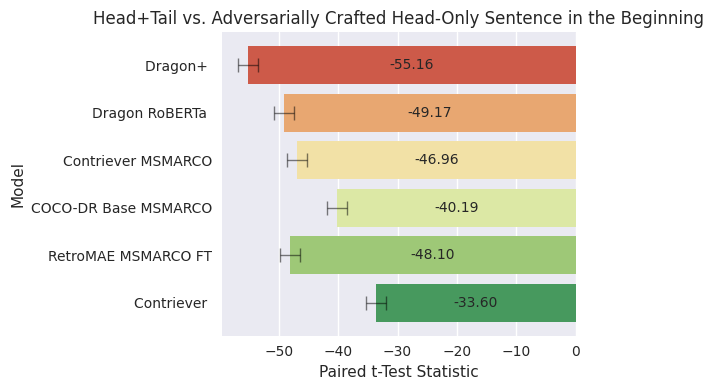

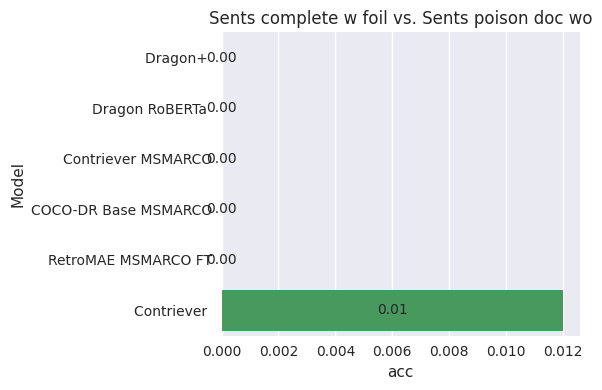

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low_stats,ttest_ci_high_stats,ttest_ci_low,ttest_ci_high,standard_ttest_ppf,acc
0,Dragon+,facebook/dragon-plus-query-encoder_sents_complete_w_foil_dot,facebook/dragon-plus-query-encoder_sents_poison_doc_wo_dot,-55.157572,1.361335e-141,-14.271007,-13.286982,1.650996,1.650996,-1.650996,0.000
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_complete_w_foil_dot,facebook/dragon-roberta-query-encoder_sents_poison_doc_wo_dot,-49.167186,3.337229e-130,-13.102762,-12.093453,1.650996,1.650996,-1.650996,0.000
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_complete_w_foil_dot,facebook/contriever-msmarco_sents_poison_doc_wo_dot,-46.956396,1.037560e-125,-0.697908,-0.641718,1.650996,1.650996,-1.650996,0.000
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_complete_w_foil_dot,OpenMatch/cocodr-base-msmarco_sents_poison_doc_wo_dot,-40.191927,7.572335e-111,-9.485721,-8.599486,1.650996,1.650996,-1.650996,0.000
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_foil_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_poison_doc_wo_dot,-48.101983,4.647639e-128,-15.975917,-14.719109,1.650996,1.650996,-1.650996,0.000
0,Contriever,facebook/contriever_sents_complete_w_foil_dot,facebook/contriever_sents_poison_doc_wo_dot,-33.599408,1.736704e-94,-0.331149,-0.294476,1.650996,1.650996,-1.650996,0.012


In [14]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and "_w_" in col1:
                ttest = stats.ttest_rel(df[col1], df[col2])
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": ttest[0],
                    "ttest_pvalue": ttest[1],
                    "ttest_ci_low_stats": ttest.confidence_interval(confidence_level=0.95)[0],
                    "ttest_ci_high_stats": ttest.confidence_interval(confidence_level=0.95)[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "standard_ttest_ppf": standard_ttest_ppf(len(df)),
                    "acc": (df[col1] > df[col2]).mean(),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("acc", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"Head+Tail vs. Adversarially Crafted Head-Only Sentence in the Beginning")
# results_df.to_json("results/tail_df.json", orient="records")
ax = sns.barplot(
    data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
plt.tight_layout()
# plt.savefig("figs/tail_foil_ttest.pdf")
plt.show()

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"{sents_cols[0].replace('_', ' ').capitalize()} vs. {sents_cols[1].replace('_', ' ').capitalize()}")
ax = sns.barplot(
    data=results_df, y="Model", x="acc", palette=sns.color_palette("RdYlGn"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig("figs/tail_foil_acc.pdf")

results_df

In [15]:
dft = results_df[["Model", "acc", "Paired t-Test Statistic", "ttest_pvalue"]]
dft["acc"] = dft["acc"].apply(lambda x: r"\textcolor{DarkRed}{" + str(np.round(x * 100, 2)) + r"\%}")
dft.rename(columns={"acc": "Accuracy", "ttest_pvalue": "p-value"}, inplace=True)
dft

def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        "Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        "Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        "query\_model": "Model",
        "llrr": r"lrrr",
        r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
        r"Paired t-Test Statistic": r"\makecell{Paired t-Test \\ Statistic}"
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = v[0] + r" " + v[1]
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str

print(clean_table(dft.round(3).to_latex(float_format="%.2f", bold_rows=True, index=False).replace("_", "\_")))
dft

\begin{tabular}{lrrr}
\toprule
Model & Accuracy & \makecell{Paired t-Test \\ Statistic} & p-value \\
\midrule
Dragon+  & \textcolor{DarkRed}{0.0\%} & -55.16 & 0.00 \\
Dragon RoBERTa  & \textcolor{DarkRed}{0.0\%} & -49.17 & 0.00 \\
Contriever MSMARCO & \textcolor{DarkRed}{0.0\%} & -46.96 & 0.00 \\
COCO-DR Base MSMARCO & \textcolor{DarkRed}{0.0\%} & -40.19 & 0.00 \\
RetroMAE MSMARCO FT & \textcolor{DarkRed}{0.0\%} & -48.10 & 0.00 \\
Contriever  & \textcolor{DarkRed}{1.2\%} & -33.60 & 0.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1231545/3765372497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["acc"] = dft["acc"].apply(lambda x: r"\textcolor{DarkRed}{" + str(np.round(x * 100, 2)) + r"\%}")
/tmp/ipykernel_1231545/3765372497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft.rename(columns={"acc": "Accuracy", "ttest_pvalue": "p-value"}, inplace=True)


,Model,Accuracy,Paired t-Test Statistic,p-value
0,Dragon+,\textcolor{DarkRed}{0.0\%},-55.157572,1.361335e-141
0,Dragon RoBERTa,\textcolor{DarkRed}{0.0\%},-49.167186,3.337229e-130
0,Contriever MSMARCO,\textcolor{DarkRed}{0.0\%},-46.956396,1.037560e-125
0,COCO-DR Base MSMARCO,\textcolor{DarkRed}{0.0\%},-40.191927,7.572335e-111
0,RetroMAE MSMARCO FT,\textcolor{DarkRed}{0.0\%},-48.101983,4.647639e-128
0,Contriever,\textcolor{DarkRed}{1.2\%},-33.599408,1.736704e-94
